# **Modelamiento de datos MT**

Autores

- **Daniela Quintero**: [yejoandajudi200305@gmail.com](mailto:yejoandajudi200305@gmail.com)
- **Paul Goyes**: [goyes.yesid@gmail.com](mailto:goyes.yesid@gmail.com) 

Importar las librerías necesarias

In [1]:
import numpy as np
from simpeg import maps
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from simpeg.utils import plot_1d_layer_model
from discretize import TensorMesh
from simpeg import maps, utils, data

# MT
from simpeg.electromagnetics import natural_source as nsem

# TDEM
import os
import pygimli as pg
import simpeg.electromagnetics.time_domain as tdem
from pygimli.physics.em import VMDTimeDomainModelling
from pygimli.viewer.mpl import drawModel1D

mpl.rcParams.update({"font.size": 16})
write_output = False

# Modelamiento MT

In [2]:
def run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=0.05, floor_phase=2):
    mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "N")

    #mesh_plot = mesh.plot_grid() ###

    wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
    sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
    layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


    sigma_map = maps.ExpMap(nP=len(rho_layers))

    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    ### CORRECCIÓN ---
    survey = nsem.survey.Survey(source_list) ### Antes -> survey = nsem.survery.Survey(source_list)

    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses,
    )

    true_model = np.r_[np.log(1./rho_layers)]

    dpred = simulation.dpred(true_model)
    rho_app = dpred.reshape((len(frequencies), 2))[:,0]
    phase = dpred.reshape((len(frequencies), 2))[:,1]
    std = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()
    noise = np.c_[np.random.randn(rho_app.size)*relative_error_rho*abs(rho_app), np.random.randn(rho_app.size)*floor_phase].flatten()
    dobs = dpred + noise
    return dobs, dpred

In [3]:
layer_tops = np.r_[0., -500., -1500., -2150., -3650., -5650.][::-1]  # in m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[150., 30, 3., 50., 8., 50.][::-1]
frequencies = np.logspace(-3, 3, 20)
relative_error_rho = 0.01
floor_phase = 0.01
dobs, dpred = run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=relative_error_rho, floor_phase=floor_phase)

C:\Users\DANIELA\AppData\Local\Temp\ipykernel_19292\1500160823.py:14: FutureWarning: PointNaturalSource has been deprecated, please use Impedance. It will be removed in version 0.24.0 of SimPEG.
  nsem.receivers.PointNaturalSource(component="app_res"),
C:\Users\DANIELA\anaconda3\envs\simpeg0230v3\Lib\site-packages\simpeg\utils\code_utils.py:565: FutureWarning: Using the default for locations is deprecated behavior. Please explicitly set locations. 
  self._old__init__(*args, **kwargs)
C:\Users\DANIELA\AppData\Local\Temp\ipykernel_19292\1500160823.py:15: FutureWarning: PointNaturalSource has been deprecated, please use Impedance. It will be removed in version 0.24.0 of SimPEG.
  nsem.receivers.PointNaturalSource(component="phase"),


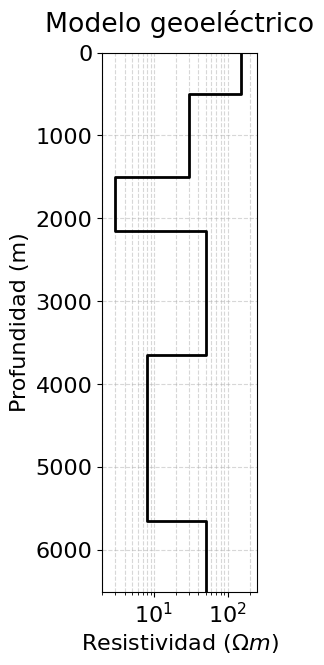

In [4]:
# Graficar el modelo
fig, ax = plt.subplots(figsize=(2, 7))
ax = plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax, color="black", label="Modelo teórico", lw= 2)
ax.set_xlabel(r"Resistividad ($\Omega m$)")
ax.set_ylabel(r"Profundidad (m)")
#ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
ax.set_ylim(6500, 0)
ax.set_xlim([10**0.3, 10**2.4])
ax.set_title("Modelo geoeléctrico", pad=15)
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
#plt.tight_layout()

filename = "Modelogeotérmico.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')

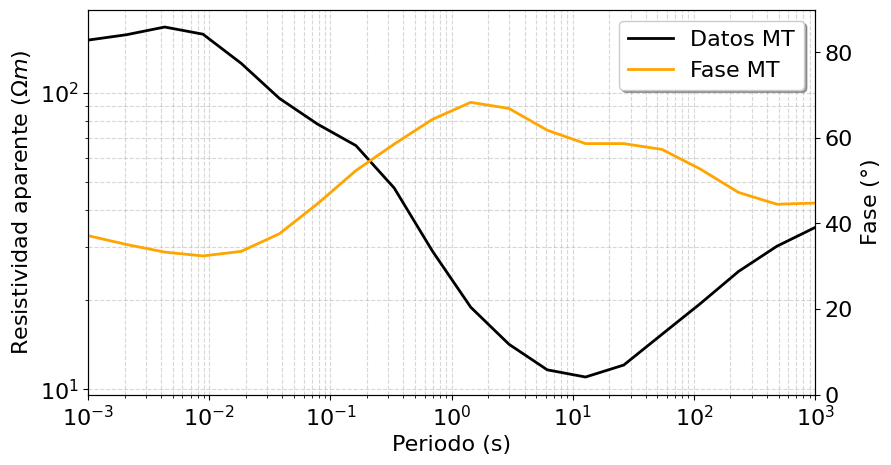

In [7]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(1/frequencies, dobs.reshape((len(frequencies), 2))[:,0],  color='black', label='Datos MT', lw =2)
ax.loglog(1/frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='orange', label='Fase MT',  lw =2)
ax.grid(True, which="both", linestyle='--', alpha=0.5)
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax.set_xlabel("Periodo (s)")  
ax.set_xlim(1/frequencies.max(), 1/frequencies.min())

ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='orange', lw = 2)  
ax_1.set_ylim(0, 90)    
ax_1.set_ylabel("Fase ($\degree$)")
ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)

filename = "DatosMT.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')
plt.show()

plt.show()

In [6]:
# Crear un diccionario con los datos
DatosMT = {"dobs": dobs, "frequencies": frequencies}

# Guardar en un solo archivo .npy
np.save("DatosMT", DatosMT)

# Modelamiento TDEM | Simpeg

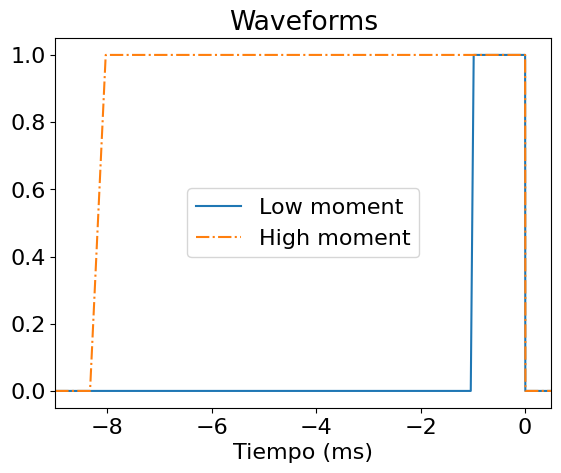

In [8]:
# Definir waveform

# Low moment
lm_waveform_times = np.r_[-1.041E-03, -9.850E-04, 0.000E+00, 4.000E-06]
lm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

# High moment
hm_waveform_times = np.r_[-8.333E-03, -8.033E-03, 0.000E+00, 5.600E-06]
hm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

plt.figure()
plt.title('Waveforms')
plt.plot(np.r_[-9, lm_waveform_times*1e3, 2], np.r_[0, lm_waveform_current, 0],
         label='Low moment')
plt.plot(np.r_[-9, hm_waveform_times*1e3, 2], np.r_[0, hm_waveform_current, 0],
         '-.', label='High moment')
plt.xlabel('Tiempo (ms)')
plt.xlim([-9, 0.5])
plt.legend()
plt.show()

waveform_LM = tdem.sources.PiecewiseLinearWaveform(
    times=lm_waveform_times, currents=lm_waveform_current
)

waveform_HM = tdem.sources.PiecewiseLinearWaveform(
    times=hm_waveform_times, currents=hm_waveform_current
)

In [9]:
# Receptores

receiver_location = np.array([0, 0, 0])
receiver_orientation = "z"  # "x", "y" or "z"

tiempo = np.logspace(-5,-2.5,25)
times = tiempo.copy()

receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times, orientation=receiver_orientation
    )
)

# Fuente

source_location = np.array([
    [-20, -20, 0],        # Vértice 1 (punto de inicio)
    [20, -20, 0],     # Vértice 2
    [20, 20, 0],  # Vértice 3
    [-20, 20, 0],     # Vértice 4
    [-20, -20, 0]         # Cerrar el bucle (vuelve al punto de inicio)
])

source_list = [tdem.sources.LineCurrent(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform_HM,),

        tdem.sources.LineCurrent(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform_LM,)
]

# Definir el arreglo
surveyTDEM = tdem.Survey(source_list)

In [10]:
# Número de capas
nlay = len(rho_layers)

resistivity_model  = rho_layers.copy()
model_map = maps.IdentityMap(nP=nlay)

In [11]:
simulationTDEM = tdem.simulation_1d.Simulation1DLayered(
    survey=surveyTDEM,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

In [12]:
dpredTDEM = simulationTDEM.dpred(resistivity_model)
dpredTDEM.shape

(50,)

In [13]:
dpred_HM = dpredTDEM[:25]
dpred_LM = dpredTDEM[25:]

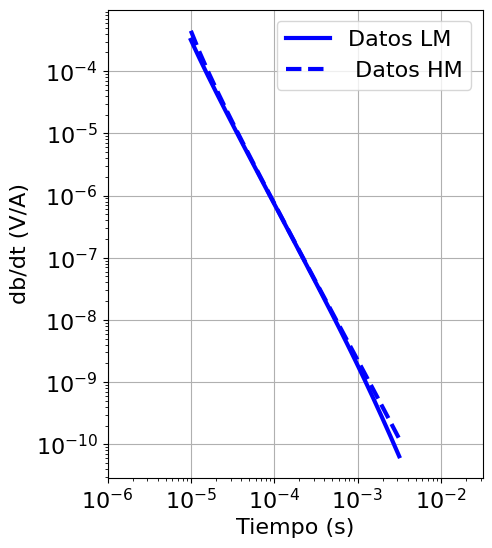

In [14]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, -dpred_LM, "b-", lw=3, label='Datos LM')
ax.loglog(times, -dpred_HM, "b--", lw=3, label=' Datos HM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("db/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [15]:
# Crear un diccionario con los datos
DatosSEDT_2 = {"dobsTDEM": dpredTDEM, "times": times}

# Guardar en un solo archivo .npy
np.save("DatosSEDTdbdt", DatosSEDT_2)

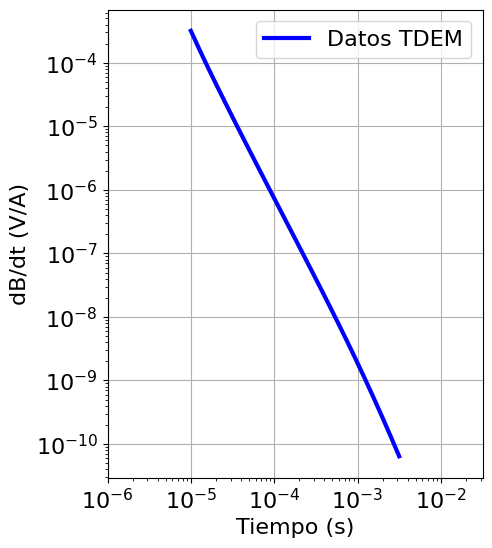

In [16]:
from scipy import interpolate
x = np.concatenate((times, times))
y = np.concatenate((-dpred_HM, -dpred_LM))
f = interpolate.interp1d(x, y)

times_ok = np.logspace(np.log10(np.min(times)),np.log10(np.max(times)),25)
dpredTDEM_ok = f(times_ok)   # use interpolation function returned by `interp1d`



fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times_ok, dpredTDEM_ok, "b-", lw=3, label='Datos TDEM')
#ax.loglog(xnew, ynew, "r--", lw=3, label='dpred_HM')

#ax.loglog(time_LM, dobs_LM, "b.",  label='dobs_LM')
#ax.loglog(time_HM, dobs_HM, "r.", label='dobs_HM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("dB/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [17]:
from pygimli.physics.em import rhoafromU

In [18]:
rhoa_TDEM = rhoafromU(U= dpredTDEM_ok, t= times_ok, Tx= 10000, Rx= 0.8)

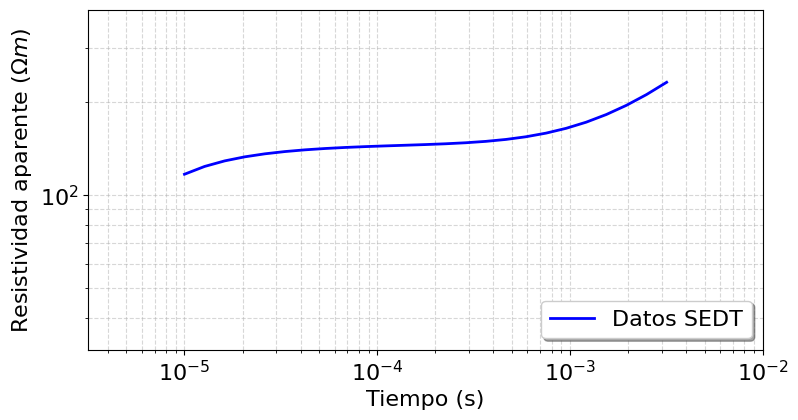

In [19]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax.loglog(times_ok, rhoa_TDEM, "b-", lw=2, label='Datos SEDT')
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**1.5, 10**2.6])
ax.set_xlim([10**-5.5, 10**-2])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

#plt.tight_layout()

filename = "DatosSEDT.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [19]:
# Crear un diccionario con los datos
DatosSEDT = {"dobsTDEM": rhoa_TDEM, "times": times_ok}

# Guardar en un solo archivo .npy
np.save("DatosSEDTrhoa", DatosSEDT)

In [20]:
f1 = 0.194 / times

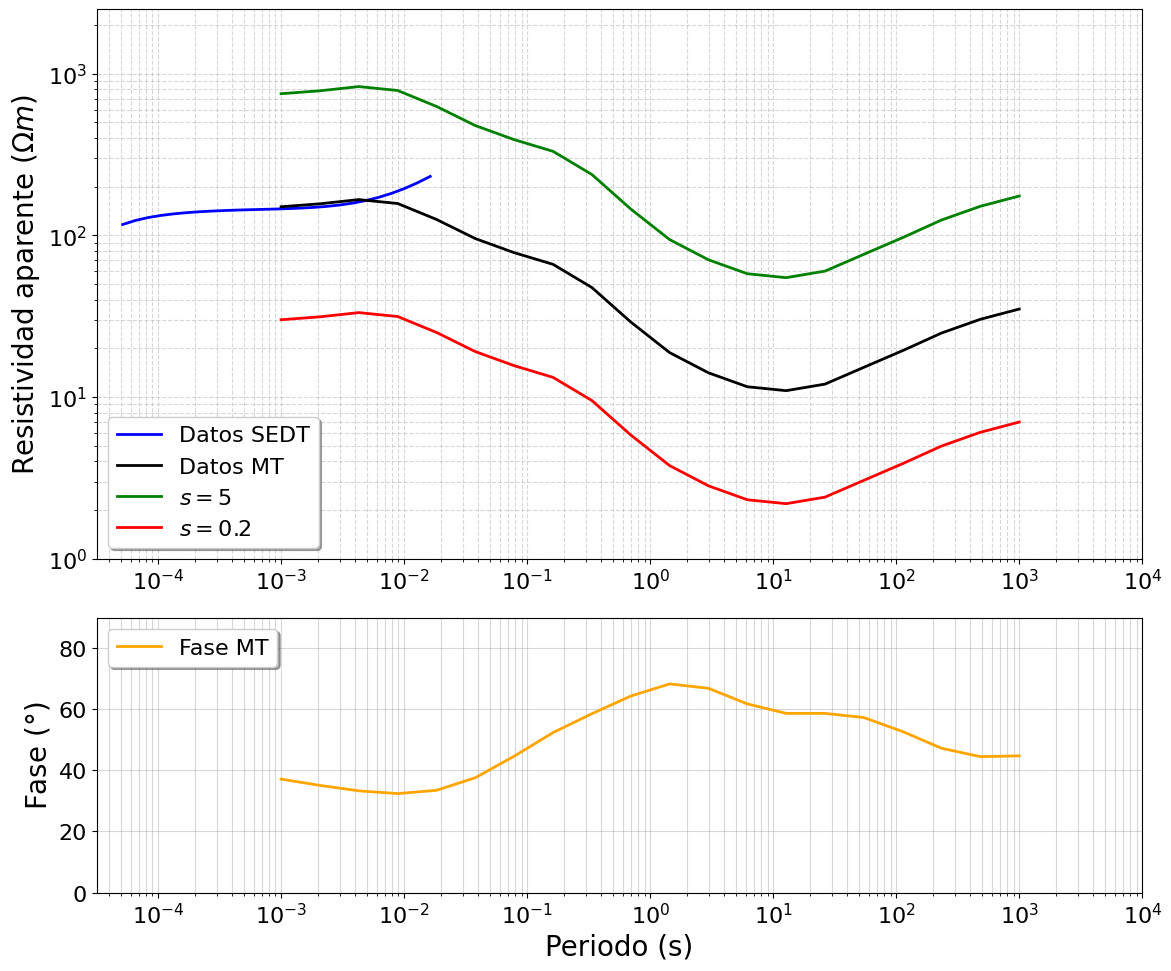

In [32]:
# Crear la figura y los subgráficos
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])  # 2 filas, 1 columna

# Gráfico superior: Resistividad aparente
ax0 = fig.add_subplot(gs[0])
ax0.loglog(1/f1, rhoa_TDEM, "blue", label='Datos SEDT', lw=2)
ax0.loglog((1/frequencies), dobs.reshape((len(frequencies), 2))[:, 0], "black", label='Datos MT', lw=2)
ax0.loglog((1/frequencies), (5 * dobs.reshape((len(frequencies), 2))[:, 0]), "green", label='$\mathit{s}=5$', lw=2)  # Corregido
ax0.loglog(1/frequencies, (1/5 * dobs.reshape((len(frequencies), 2))[:, 0]), "red", label='$\mathit{s}=0.2$', lw=2)  # Corregido

# Configuración del gráfico de resistividad aparente
ax0.set_ylim([10**0, 10**3.4])
ax0.set_xlim([10**-4.5, 10**4])
ax0.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
ax0.set_ylabel("Resistividad aparente ($\Omega m$)", fontsize= 20)
ax0.legend(loc='lower left', frameon=True, shadow=True, fancybox=True)

# Gráfico inferior: Fase
ax1 = fig.add_subplot(gs[1])
ax1.semilogx(frequencies, dobs.reshape((len(frequencies), 2))[:, 1], linestyle="-", color='orange', label='Fase MT', lw=2)

# Configuración del gráfico de fase
ax1.set_ylim([0, 90])
ax1.set_xlim([10**-4.5, 10**4])
ax1.grid(True, which="both", linestyle='-', alpha=0.5)  # Grilla sutil
ax1.set_xlabel("Periodo (s)", fontsize= 20)
ax1.set_ylabel("Fase ($\degree$)", fontsize= 20)
ax1.legend(loc='upper left', frameon=True, shadow=True, fancybox=True)

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Guardar la figura
filename = "staticshift.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')

plt.show()

# Modelamiento TDEM | Pygimli

In [23]:
import pygimli as pg
from pygimli.physics.em import VMDTimeDomainModelling

from pygimli.physics.em import HEMmodelling
from pygimli.physics.ves import VESModelling
from pygimli.frameworks import JointModelling
from pygimli.frameworks import MarquardtInversion
from pygimli.frameworks.lsqrinversion import LSQRInversion
from pygimli.viewer.mpl import drawModel1D

In [24]:
h = layer_thicknesses.tolist()
print(h)

l = rho_layers.tolist()
print(l)

[2000.0, 1500.0, 650.0, 1000.0, 500.0]
[50.0, 8.0, 50.0, 3.0, 30.0, 150.0]


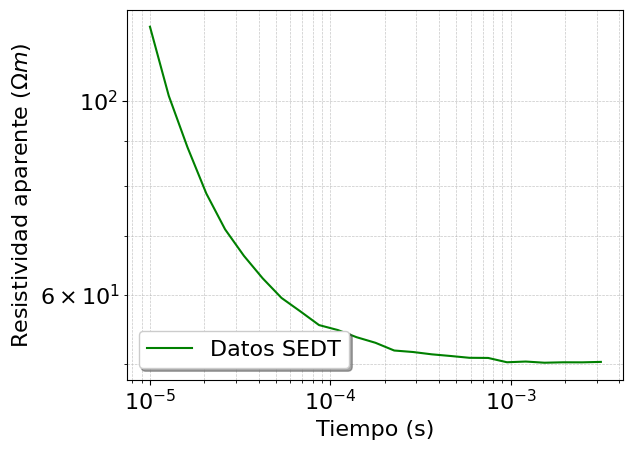

In [25]:
#Modelado directo del método SEDT
errorEMabs = 0.3
times = np.logspace(-5,-2.5,25)
TDEM = VMDTimeDomainModelling(times=times, txArea=10000, rxArea=5,nLayers=nlay)
dataTDEM = pg.Vector( TDEM(h+l))

errorTDEM = np.ones_like(dataTDEM) * errorEMabs / 100.
dataTDEM *= 1. + pg.randn(len(dataTDEM), seed=1234) * errorTDEM
dataTDEM
plt.loglog(times,dataTDEM, color="green", label="Datos SEDT")
plt.xlabel("Tiempo (s)")
plt.ylabel("Resistividad aparente ($\Omega m$)")
plt.legend(loc="lower left", frameon=True, shadow=True)
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

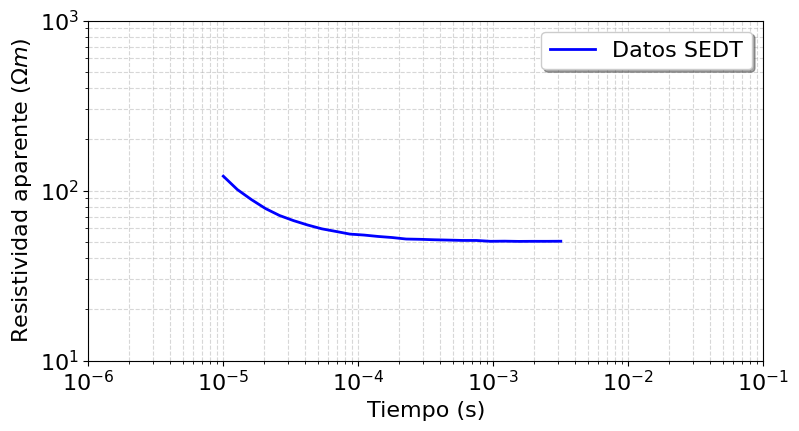

In [26]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax.loglog(times, dataTDEM, "b-", lw=2, label='Datos SEDT')
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**1, 10**3])
ax.set_xlim([10**-6, 10**-1])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
#filename = "DatosSEDT.png"
#plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')
plt.show()

In [27]:
f = 0.2/ times

In [28]:
f1 = 0.194 / times

In [29]:
dataMT = dobs.reshape((len(frequencies), 2))[:,0]

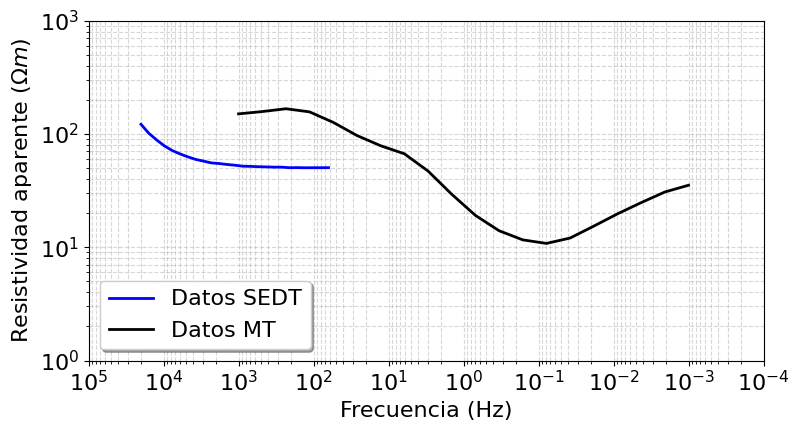

In [30]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax.loglog(f, dataTDEM, "blue",  label='Datos SEDT', lw=2)
ax.loglog(frequencies, dataMT, "black", label='Datos MT', lw=2)
#ax.loglog(frequencies, (5*dataMT), "green", label='$\mathit{s}=5$', lw=2)
#ax.loglog(frequencies, (1/5*dataMT), "red", label='$\mathit{s}=0.2$', lw=2)

ax.set_xlabel("Frecuencia (Hz)")
ax.set_ylabel("Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**0, 10**3])
ax.set_xlim([10**5, 10**-4])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower left', frameon=True, shadow=True, fancybox=True)
plt.show()